In [167]:
import glob
import os

import numpy as np
import pandas as pd
import scipy.signal
import scipy

# Image processing tools
import skimage
import skimage.io as io
import scipy.ndimage as ndimage

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline

In [200]:
blank_img = io.imread('./practice_strokes/blank.png')
basic_img = io.imread('./practice_strokes/black_basic_1.png')
hard_img = io.imread('./practice_strokes/garden.jpg')

In [201]:
hard_img = ndimage.gaussian_filter(hard_img, sigma=(3, 3, 0), order=0)

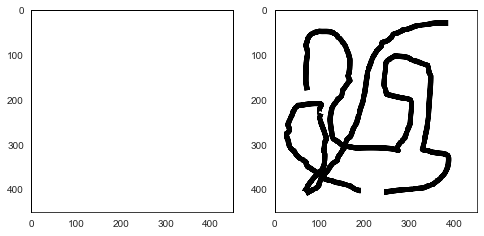

In [202]:
with sns.axes_style('dark'):
    # Get subplots
    fig, ax = plt.subplots(1,2, figsize=(8,6))
    ax[0].imshow(blank_img)
    ax[1].imshow(basic_img)

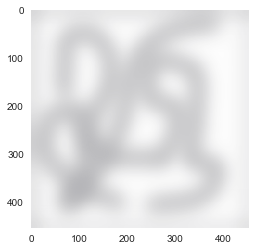

In [203]:
basic_gauss = scipy.ndimage.filters.gaussian_filter(basic_img, 20, mode='reflect')

with sns.axes_style('dark'):
    plt.imshow(basic_gauss)

(450, 625, 3)


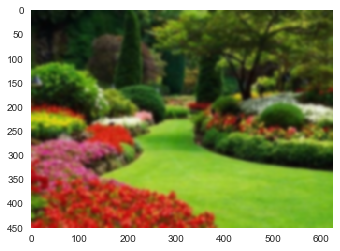

In [204]:
print(hard_img.shape)
with sns.axes_style('dark'):
    plt.imshow(hard_img)

In [173]:
print(hard_img)

[[[ 70  65  62]
  [ 70  65  62]
  [ 70  65  62]
  ..., 
  [133 128 125]
  [133 128 125]
  [133 128 125]]

 [[ 70  65  62]
  [ 70  65  62]
  [ 70  65  62]
  ..., 
  [135 130 127]
  [134 129 126]
  [134 129 126]]

 [[ 71  66  63]
  [ 71  66  63]
  [ 71  66  63]
  ..., 
  [137 132 129]
  [137 132 129]
  [137 132 129]]

 ..., 
 [[ 66  62  59]
  [ 66  62  59]
  [ 66  62  58]
  ..., 
  [168 163 160]
  [168 163 160]
  [169 164 161]]

 [[ 64  60  57]
  [ 64  60  57]
  [ 64  60  56]
  ..., 
  [167 162 159]
  [167 162 159]
  [167 162 159]]

 [[ 63  59  56]
  [ 63  59  56]
  [ 63  59  56]
  ..., 
  [166 161 158]
  [166 161 158]
  [167 162 159]]]


In [174]:
current_painting = np.ones(shape=hard_img.shape, dtype=np.uint8) * 255

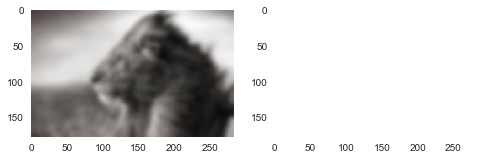

In [175]:
with sns.axes_style('dark'):
    # Get subplots
    fig, ax = plt.subplots(1,2, figsize=(8,6))
    ax[0].imshow(hard_img)
    ax[1].imshow(current_painting)

In [176]:
d = 10

In [177]:
def calculate_distortion(original, current):
    error = np.zeros(shape=original.shape)
    for x in range(len(original)):
        for y in range(len(original[0])):
            error[x][y] = [np.absolute(int(a) - int(b)) for a,b in zip(original[x][y], current[x][y])]
    distortion = np.zeros(shape = error.shape[:-1])
    for x in range(len(error)):
        for y in range(len(error[0])):
            distortion[x][y] = int(np.linalg.norm(error[x][y]))
    return distortion

In [178]:
def smooth_distortion(distortion_mag, r):
    smoothened_distortion = np.zeros(shape = distortion.shape)
    for x in range(len(distortion)):
        for y in range(len(distortion[0])):
            sum_around = 0
            num_around = 0
            for poss_x in range(x - r, x + r + 1):
                for poss_y in range(y - r, y + r + 1):
                    if poss_x >= 0 and poss_x < len(distortion) and poss_y >= 0 and poss_y < len(distortion[0]):
                        if np.power(poss_x - x, 2) + np.power(poss_y - y, 2) <= r*r:
                            sum_around += distortion[poss_x][poss_y]
                            num_around += 1
            smoothened_distortion[x][y] = int(sum_around / num_around)
            #print(sum_around, num_around)
    return np.array(smoothened_distortion)

def smooth_distortion2(distortion, r):
    img = ndimage.gaussian_filter(distortion, sigma=(r, r), order=0)
    return img

In [179]:
distortion = calculate_distortion(hard_img, current_painting)
smoothened_distortion = smooth_distortion2(distortion, int(d/2))
print(distortion.shape)
print(smoothened_distortion.shape)

(177, 284)
(177, 284)


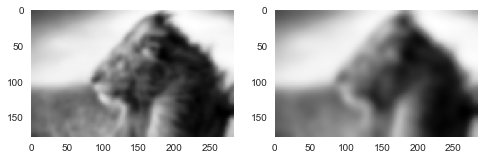

In [180]:
with sns.axes_style('dark'):
    ig, ax = plt.subplots(1,2, figsize=(8,6))
    ax[0].imshow(distortion)
    ax[1].imshow(smoothened_distortion)

In [181]:
print(hard_img[50][283])
print(hard_img[100][250])

print(smoothened_distortion[50][283])
print(smoothened_distortion[100][250])

[230 228 229]
[31 30 28]
39.2087164494
383.702776301


In [182]:
def get_distortion_threshold(distortion):
    n = int(0.1 * len(distortion))
    top = np.partition(distortion.flatten(), -n)[-n]
    return top

def choose_pixel(original, distortion, top):
    x = np.random.randint(len(distortion))
    y = np.random.randint(len(distortion[0]))
    while distortion[x][y] < top:
        x = np.random.randint(len(distortion))
        y = np.random.randint(len(distortion[0]))
    x_min = int(max(0,x-0.5*d))
    x_max = int(min(len(original), x+0.5*d))
    y_min = int(max(0,y-0.5*d))
    y_max = int(min(len(original[0]), y+0.5*d))
    lst = original[x_min:x_max, y_min:y_max,:]
    lst = np.reshape(lst, (len(lst)*len(lst[0]), 3)).tolist()
    lst_string = ['_'.join([str(x) for x in y]) for y in lst]
    color = max(set(lst_string), key=lst_string.count)
    color = [int(x) for x in color.split('_')]
    return x, y, color

In [183]:
thresh = get_distortion_threshold(smoothened_distortion)
x, y, c = choose_pixel(hard_img, smoothened_distortion, thresh)
print(x, y, c)

144 264 [13, 12, 12]


In [184]:
def get_stroke_pixels(original, x, y, c, d):
    orientations = [0.0, 22.5, 45.0, 67.5, 90.0, 112.5, 135.0, 157.5]
    o = orientations[np.random.randint(8)] * np.pi / 180.0
    step = 1
    r = int(d/2)

    curr_x = x
    curr_y = y
    cont = True
    pixels = []
    xrold = x
    yrold = y
    while cont:
        xr = int(curr_x)
        yr = int(curr_y)
        new_pixels = []
        new_colors = []
        for poss_x in range(xr - r, xr + r + 1):
            for poss_y in range(yr - r, yr + r + 1):
                if poss_x >= 0 and poss_x < len(original) and poss_y >= 0 and poss_y < len(original[0]):
                    if np.power(poss_x - xr, 2) + np.power(poss_y - yr, 2) <= r*r:
                        if [poss_x, poss_y] not in pixels:
                            new_pixels.append([poss_x, poss_y])
                            new_colors.append([a - b for a,b in zip(original[poss_x][poss_y], c)])

        if len(new_pixels) == 0:
            if xr == xrold and yr == yrold:
                cont = True
            else:
                cont = False
        else:
            stddevs = np.std(new_colors, axis=0)
            if np.all(stddevs < 10.0):
                pixels = pixels + new_pixels
            else:
                cont = False

        curr_x += step * np.cos(o)
        curr_y += step * np.sin(o)
        xrold = xr
        yrold = yr
    
    curr_x = x - step * np.cos(o)
    curr_y = y - step * np.sin(o)
    cont = True
    xrold = x
    yrold = y
    while cont:
        xr = int(curr_x)
        yr = int(curr_y)
        new_pixels = []
        new_colors = []
        for poss_x in range(xr - r, xr + r + 1):
            for poss_y in range(yr - r, yr + r + 1):
                if poss_x >= 0 and poss_x < len(original) and poss_y >= 0 and poss_y < len(original[0]):
                    if np.power(poss_x - xr, 2) + np.power(poss_y - yr, 2) <= r*r:
                        if [poss_x, poss_y] not in pixels:
                            new_pixels.append([poss_x, poss_y])
                            new_colors.append([a - b for a,b in zip(original[poss_x][poss_y], c)])

        if len(new_pixels) == 0:
            if xr == xrold and yr == yrold:
                cont = True
            else:
                cont = False
        else:
            stddevs = np.std(new_colors, axis=0)
            if np.all(stddevs < 10.0):
                pixels = pixels + new_pixels
            else:
                cont = False

        curr_x -= step * np.cos(o)
        curr_y -= step * np.sin(o)
        xrold = xr
        yrold = yr

    return(pixels)

In [185]:
def draw_stroke(current, original, x, y, c):
    pixels = get_stroke_pixels(original, x, y, c, d)
    for pixel in pixels:
        current[pixel[0]][pixel[1]] = c
    return current, pixels

In [216]:
def draw_n_strokes(current, original, distortion, num_strokes):
    thresh = get_distortion_threshold(distortion)
    print(thresh)
    for i in range(num_strokes):
        j = 0
        pixels = []
        while len(pixels) == 0 and j < 200:
            x, y, c = choose_pixel(original, distortion, thresh)
            current, pixels = draw_stroke(current, original, x, y, c)
            j+=1
            print(j, c)
    return current

In [217]:
current_painting = np.ones(shape=hard_img.shape, dtype=np.uint8) * 255
d = 6

In [218]:
for j in range(10):
    print(j)
    distortion = calculate_distortion(hard_img, current_painting)
    smoothened_distortion = smooth_distortion2(distortion, int(d/2))
    current_painting = draw_n_strokes(current_painting, hard_img, smoothened_distortion, 10)

0
432.507418292
1 [4, 5, 6]
1 [4, 5, 6]
1 [5, 5, 5]
1 [4, 5, 6]
1 [4, 5, 6]
1 [4, 5, 6]
1 [3, 5, 6]
1 [4, 5, 6]
1 [5, 5, 5]
1 [5, 5, 5]
1
423.593774461
1 [8, 10, 7]
1 [8, 10, 7]
1 [9, 12, 8]
1 [8, 10, 7]
1 [9, 12, 8]
1 [9, 10, 8]
1 [9, 12, 8]
1 [9, 12, 8]
1 [8, 10, 7]
1 [8, 10, 7]
2
420.757921254
1 [9, 11, 8]
1 [9, 9, 6]
1 [7, 16, 7]
1 [7, 16, 7]
1 [7, 16, 7]
1 [7, 16, 7]
1 [7, 16, 7]
1 [9, 9, 6]
1 [7, 16, 7]
1 [7, 16, 7]
3
419.238222062
1 [11, 12, 9]
1 [11, 12, 7]
1 [15, 7, 4]
1 [11, 12, 7]
1 [11, 12, 9]
1 [11, 12, 9]
1 [11, 12, 8]
1 [11, 12, 9]
1 [11, 12, 9]
1 [15, 7, 4]
4
417.459743712
1 [9, 12, 7]
1 [9, 12, 7]
1 [9, 12, 7]
1 [12, 14, 6]
1 [11, 15, 9]
1 [11, 15, 9]
1 [12, 14, 6]
1 [9, 12, 7]
1 [9, 12, 7]
1 [12, 14, 6]
5
416.644242668
1 [18, 13, 4]
1 [19, 13, 4]
1 [12, 15, 10]
1 [19, 13, 4]
1 [12, 15, 10]
1 [19, 13, 4]
1 [4, 20, 11]
1 [12, 15, 10]
1 [12, 15, 10]
1 [12, 15, 10]
6
413.994514329
1 [7, 21, 12]
1 [1, 11, 7]
1 [14, 26, 15]
1 [7, 12, 7]
1 [2, 10, 6]
1 [4, 15, 10]
1 [7, 24, 

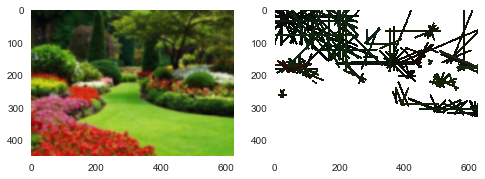

In [215]:
with sns.axes_style('dark'):
    ig, ax = plt.subplots(1,2, figsize=(8,6))
    ax[0].imshow(hard_img)
    ax[1].imshow(current_painting)

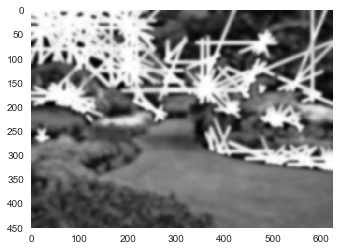

In [211]:
with sns.axes_style('dark'):
    plt.imshow(smoothened_distortion)

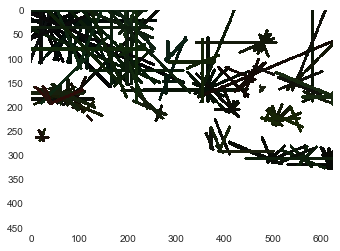

In [212]:
with sns.axes_style('dark'):
    plt.imshow(current_painting)

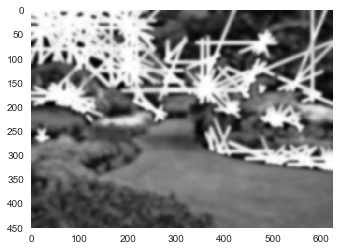

In [213]:
with sns.axes_style('dark'):
    plt.imshow(smoothened_distortion)

In [214]:
print(current_painting)

[[[  9  30  13]
  [  9  30  13]
  [  9  30  13]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[  9  30  13]
  [  9  30  13]
  [  9  30  13]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[  9  30  13]
  [  9  30  13]
  [  9  30  13]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ..., 
 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
